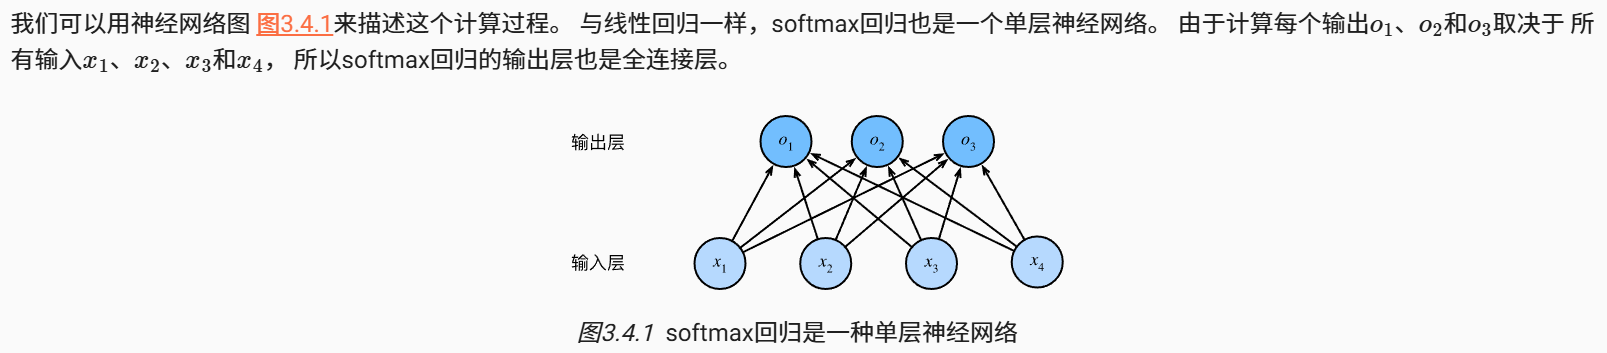


In [2]:
import time

#matplotlib inline
from matplotlib_inline import backend_inline
import torch
import torchvision
from torch.ao.nn.quantized import Softmax
from torch.utils import data
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np



backend_inline.set_matplotlib_formats('svg')
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("CUDA current device:", torch.cuda.current_device())

PyTorch version: 2.7.1+cu128
Torchvision version: 0.22.1+cu128
CUDA available: True
CUDA device count: 1
CUDA current device: 0


下载数据集，转换为tensor格式

In [3]:
trans = transforms.ToTensor()
# Fashion-MNIST数据集
# root: 数据集存放路径
# train: True表示训练集，False表示测试集
# transform: 对数据进行的变换
# download: True表示如果本地没有数据集就从网上下载
mnist_train = torchvision.datasets.FashionMNIST(
    root="./data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="./data", train=False, transform=trans, download=True)

In [3]:
len(mnist_train), len(mnist_test)

(60000, 10000)

数据集的每个样本是一个通道数为1，像素为28x28的灰度图像，对应的标签是一个0-9的数字

In [4]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [5]:
mnist_train[0][1]

9

In [4]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [5]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    # 创建一个图形和一组子图
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    # 如果axes是一个二维数组，则将其展平为一维数组
    if not isinstance(axes, (list, np.ndarray)):
        axes = [axes]
    else:
        axes = axes.flatten()

    # 打包图像和标题，遍历
    for i, (img, ax) in enumerate(zip(imgs, axes)):

        # 如果是tensor类型，则转换为numpy数组
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)

        # 设置x轴和y轴不可见
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    plt.show()

In [6]:
X ,y =  next(iter(data.DataLoader(mnist_train, batch_size=1)))
# show_images(X.reshape(1, 28, 28), 1, 1, titles=get_fashion_mnist_labels(y))

In [7]:
batch_size = 256

def get_dataloader_workers():
    return 4

train_iter = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True,num_workers=get_dataloader_workers())

import time

start = time.time()
for X,y in train_iter:
    continue

end = time.time()
f'{end - start:.2f} sec'



'10.76 sec'

In [8]:

def load_data_fashion_mnist(batch_size,resize=None):
    '''
    加载Fashion-MNIST数据集
    :param batch_size: 批量大小
    :param resize: 如果不为None，则将图像大小调整为指定的大小
    :return:
    '''

    # 定义一个变换列表，初始包含将图像转换为tensor的变换
    trans = [transforms.ToTensor()]

    # 如果指定了resize参数，则添加Resize变换
    if resize:
        # 在列表的开头插入Resize变换，将图像大小调整为指定的大小
        trans.insert(0, transforms.Resize(resize))

    # 使用Compose将多个变换组合在一起
    trans = transforms.Compose(trans)

    mnist_train = torchvision.datasets.FashionMNIST(
        root="./data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="./data", train=False, transform=trans, download=True)

    train_dataloader = data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=get_dataloader_workers())
    test_dataloader = data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=get_dataloader_workers())

    return train_dataloader, test_dataloader

In [9]:
train_iter, test_iter = load_data_fashion_mnist(batch_size)

for X,y in train_iter:
    print(X.shape,X.dtype,y.shape,y.dtype)
    break

torch.Size([256, 1, 28, 28]) torch.float32 torch.Size([256]) torch.int64


重启内核

---

# Softmax回归 从零开始实现

In [20]:
import torch
from IPython import display
import numpy as np
import torchvision
from torch.utils import data
from torchvision import transforms
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

In [21]:

def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def get_dataloader_workers():
    return 4

def load_data_fashion_mnist(_batch_size, resize=None):
    """
    加载Fashion-MNIST数据集
    :param _batch_size: 批量大小
    :param resize: 如果不为None，则将图像大小调整为指定的大小
    :return: train_dataloader, test_dataloader
    """

    # 定义一个变换列表，初始包含将图像转换为tensor的变换
    _trans = [transforms.ToTensor()]

    # 如果指定了resize参数，则添加Resize变换
    if resize:
        # 在列表的开头插入Resize变换，将图像大小调整为指定的大小
        _trans.insert(0, transforms.Resize(resize))

    # 使用Compose将多个变换组合在一起
    _trans = transforms.Compose(_trans)

    _mnist_train = torchvision.datasets.FashionMNIST(
        root="./data", train=True, transform=_trans, download=True)
    _mnist_test = torchvision.datasets.FashionMNIST(
        root="./data", train=False, transform=_trans, download=True)

    train_dataloader = data.DataLoader(_mnist_train, batch_size=_batch_size, shuffle=True, num_workers=get_dataloader_workers())
    test_dataloader = data.DataLoader(_mnist_test, batch_size=_batch_size, shuffle=False, num_workers=get_dataloader_workers())

    return train_dataloader, test_dataloader


class SoftMax:
    def __init__(self):
        self.batch_size = 256
        self.train_iter, self.test_iter = load_data_fashion_mnist(self.batch_size)
        self.num_inputs = 784  # 每个图像的输入特征数 28x28=784
        self.num_outputs = 10  # 输出类别数
        self.lr = 0.1
        # 权重矩阵是一个num_inputs x num_outputs的矩阵，取值服从均值为0，标准差为0.01的正态分布，需要梯度
        # 偏置向量是一个长度为num_outputs的向量，初始值为0，也需要梯度
        # 这里的requires_grad=True表示需要计算梯度
        self.W = torch.normal(0, 0.01, size=(self.num_inputs, self.num_outputs), requires_grad=True)
        self.b = torch.zeros(self.num_outputs, requires_grad=True)

    @classmethod
    def softmax(cls, _X):
        """
        计算softmax函数
        公式：softmax(x_i) = exp(x_i) / sum(exp(x_j)) for j in range(num_classes)
        其中x_i是第i个类别的得分，num_classes是类别总数
        :param _X: 输入数据，形状为(batch_size, num_inputs)
        :return: softmax输出，形状为(batch_size, num_outputs)
        这里的batch_size是样本数量，num_inputs是每个样本的
        """

        X_exp = torch.exp(_X)  # 对输入数据进行指数运算
        partition = X_exp.sum(1, keepdim=True)  # 计算每行的分母，即每个样本的指数和
        return X_exp / partition  # 每个元素除以对应行的分母，得到softmax输出

    def net(self, _X):
        """
        定义softmax回归模型
        :param _X: 输入数据，形状为(batch_size, num_inputs)
        :return: 模型输出，形状为(batch_size, num_outputs)
        """
        # 将输入数据展平为向量，使用-1表示自动计算批量大小
        # _X = _X.reshape((-1, self.num_inputs))
        # 从而将每个28x28的图像展平为一个784维的向量
        # 计算线性变换的输出，即矩阵乘法加上偏置
        # torch.matmul用于矩阵乘法，_X.reshape((-1, self.W.shape[0]))将输入数据展平为(batch_size, num_inputs)的形状
        # self.W是权重矩阵，self.b是偏置向量
        # 最后将线性变换的结果输入softmax函数，得到模型输出
        # 这里的self.W.shape[0]表示权重矩阵的行数
        return self.softmax(torch.matmul( _X.reshape((-1,self.W.shape[0])),self.W) + self.b)

    @classmethod
    def cross_entropy(cls, _y_hat, _y):
        """
        计算交叉熵损失
        :param _y_hat: 模型输出，形状为(batch_size, num_outputs)
        :param _y: 真实标签，形状为(batch_size,)
        :return: 交叉熵损失
        """
        # len(_y_hat.shape) == 2, _y_hat.shape[0] == _y.shape[0]
        # 取出每个样本的预测类别的概率，并取对数
        return - torch.log(_y_hat[range(_y_hat.shape[0]), _y])

    @classmethod
    def accuracy(cls, _y_hat, _y):
        """
        计算预测正确的数量
        :param _y_hat: 模型输出，形状为(batch_size, num_outputs)
        :param _y: 真实标签，形状为(batch_size,)
        :return: 准确率
        """
        if len(_y_hat.shape) > 1 and _y_hat.shape[1] > 1:
            # 如果模型输出是一个二维张量，且第二维大于1，则取每个样本的最大值所在的索引作为预测类别
            _y_hat = _y_hat.argmax(axis=1)
        cmp = _y_hat.type(_y.dtype) == _y  # 将预测类别转换为与真实标签相同的类型，然后进行比较
        return float(cmp.type(_y.dtype).sum())  # 返回预测正确的数量

    @classmethod
    def evaluate_accuracy(cls, _net: torch.nn.Module, _data_iter: data.DataLoader):
        """
        计算在某个数据集上的准确率
        :param _net: 模型
        :param _data_iter: 数据迭代器
        :return: 准确率
        """

        # 如果模型是torch.nn.Module的子类，则将其设置为评估模式
        if isinstance(_net, torch.nn.Module):
            _net.eval()  # 将模型设置为评估模式
        metric = Accumulator(2)  # 创建一个累加器，统计正确预测的数量和总样本数量
        with torch.no_grad():  # 在评估时不需要计算梯度
            for X, y in _data_iter:
                metric.add(cls.accuracy(_net(X), y), y.numel())  # 累加正确预测的数量和总样本数量
        return metric[0] / metric[1]  # 返回准确率

    def train_epoch_ch3(self, _net, _train_iter, _loss, _updater):
        """
        训练一个epoch
        :param _net: 模型
        :param _train_iter: 训练数据迭代器
        :param _loss: 损失函数
        :param _updater: 优化器
        :return: 平均损失和准确率
        这里的_updater可以是torch.optim.Optimizer，也可以是自定义的更新
        """
        # 将模型设置为训练模式
        if isinstance(_net, torch.nn.Module):
            _net.train()
        metric = Accumulator(3)  # 创建一个累加器，统计损失和正确预测的数量
        for X, y in _train_iter:
            # 计算模型输出
            y_hat = _net(X)
            l = _loss(y_hat, y)

            if isinstance(_updater, torch.optim.Optimizer):
                # 如果优化器是torch.optim.Optimizer，则使用其step方法更新参数
                _updater.zero_grad()  # 清除梯度
                l.mean().backward()  # 计算梯度
                _updater.step()  # 更新参数
            else:
                # 否则，使用自定义的更新方法
                l.sum().backward()  # 计算梯度
                _updater(X.shape[0])  # 更新参数
            metric.add(l.sum(), self.accuracy(y_hat, y), y.numel())  # 累加损失和正确预测的数量
        # 返回平均损失和准确率
        # metric[0]是总损失，metric[1]是正确预测的数量，metric[2]是总样本数量
        return metric[0] / metric[2], metric[1] / metric[2]  # 返回平均损失和准确率

    def train_ch3(self, _net, _train_iter, _test_iter, _loss, _num_epochs, _updater):
        """

        :param _net:
        :param _train_iter:
        :param _test_iter:
        :param _loss:
        :param _num_epochs:
        :param _updater:
        :return:
        """

        train_metrics = None  # 初始化训练指标
        test_acc = None  # 初始化测试准确率

        animator = Animator(xlabel='epoch', ylabel='loss',
                        legend=['train loss', 'train acc', 'test acc'])  # 创建一个动画对象，用于绘制训练过程中的损失和准确率
        for epoch in range(_num_epochs):
            # 训练一个epoch
            train_metrics = self.train_epoch_ch3(_net, _train_iter, _loss, _updater)
            # 在测试集上评估模型
            test_acc = self.evaluate_accuracy(_net, _test_iter)
            # 绘制训练过程中的损失和准确率
            animator.add(epoch + 1, (train_metrics[0], train_metrics[1], test_acc))

        # 绘制最终的图形
        train_loss, train_acc = train_metrics
        assert train_loss < 0.5, train_loss
        assert 1 >= train_acc > 0.7, train_acc
        assert 0.7 <= test_acc <= 1, test_acc

    def update(self):
        """
        更新模型参数
        :return: 优化器
        """
        # 使用torch.optim.SGD优化器，学习率为self.lr
        return torch.optim.SGD([self.W, self.b], lr=self.lr)  # 返回一个优化器，用于更新模型参数


class Accumulator:
    """
    在n个变量上累加，每次调用add方法时，将传入的参数逐一累加到data中
    reset方法将data中的所有元素置为0.0
    """
    def __init__(self, n):
        self.data = [0.0] * n  # 初始化一个长度为n的列表，元素均为0.0

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]  # 将传入的参数逐一累加到data中

    def reset(self):
        self.data = [0.0] * len(self.data)  # 重置data，将所有元素置为0.0

    def __getitem__(self, idx):
        return self.data[idx]  # 支持通过索引访问data中的元素

def use_svg_display():  #@save中显示绘图"""
    backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):  #@save
    """设置matplotlib的图表大小"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize


def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


In [4]:
import torch
from IPython import display
import numpy as np
import torchvision
from torch.utils import data
from torchvision import transforms
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline
import logging

logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')


def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images.

    Defined in :numref:`sec_utils`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    # 将axes展平为一维数组
    axes = axes.flatten() if num_rows * num_cols > 1 else [axes]
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes


def use_svg_display():  # @save中显示绘图"""
    backend_inline.set_matplotlib_formats('svg')


def set_figsize(figsize=(3.5, 2.5)):  # @save
    """设置matplotlib的图表大小"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize


def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


def get_dataloader_workers():
    return 4


def load_data_fashion_mnist(_batch_size, resize=None):
    """
    加载Fashion-MNIST数据集
    :param _batch_size: 批量大小
    :param resize: 如果不为None，则将图像大小调整为指定的大小
    :return: train_dataloader, test_dataloader
    """

    # 定义一个变换列表，初始包含将图像转换为tensor的变换
    _trans = [transforms.ToTensor()]

    # 如果指定了resize参数，则添加Resize变换
    if resize:
        # 在列表的开头插入Resize变换，将图像大小调整为指定的大小
        _trans.insert(0, transforms.Resize(resize))

    # 使用Compose将多个变换组合在一起
    _trans = transforms.Compose(_trans)

    _mnist_train = torchvision.datasets.FashionMNIST(
        root="./data", train=True, transform=_trans, download=True)
    _mnist_test = torchvision.datasets.FashionMNIST(
        root="./data", train=False, transform=_trans, download=True)

    train_dataloader = data.DataLoader(_mnist_train, batch_size=_batch_size, shuffle=True,
                                       num_workers=get_dataloader_workers())
    test_dataloader = data.DataLoader(_mnist_test, batch_size=_batch_size, shuffle=False,
                                      num_workers=get_dataloader_workers())

    return train_dataloader, test_dataloader


class Accumulator:
    """
    在n个变量上累加，每次调用add方法时，将传入的参数逐一累加到data中
    reset方法将data中的所有元素置为0.0
    """

    def __init__(self, n):
        self.data = [0.0] * n  # 初始化一个长度为n的列表，元素均为0.0

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]  # 将传入的参数逐一累加到data中

    def reset(self):
        self.data = [0.0] * len(self.data)  # 重置data，将所有元素置为0.0

    def __getitem__(self, idx):
        return self.data[idx]  # 支持通过索引访问data中的元素


class Animator:  # @save
    """在动画中绘制数据"""

    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        plt.draw()
        plt.pause(0.1)
        display.clear_output(wait=True)


class SoftMax:
    def __init__(self):
        logging.info('初始化SoftMax模型...')
        self.batch_size = 256
        self.train_iter, self.test_iter = load_data_fashion_mnist(self.batch_size)
        logging.info(f'加载数据完成，batch_size={self.batch_size}')
        self.num_inputs = 784  # 每个图像的输入特征数 28x28=784
        self.num_outputs = 10  # 输出类别数
        self.lr = 0.1
        self.W = torch.normal(0, 0.01, size=(self.num_inputs, self.num_outputs), requires_grad=True)
        self.b = torch.zeros(self.num_outputs, requires_grad=True)
        logging.info(f'模型参数初始化完成: num_inputs={self.num_inputs}, num_outputs={self.num_outputs}, lr={self.lr}')
        logging.debug(f'权重W: {self.W}')
        logging.debug(f'偏置b: {self.b}')

    @classmethod
    def softmax(cls, _X):
        """
        计算softmax函数
        公式：softmax(x_i) = exp(x_i) / sum(exp(x_j)) for j in range(num_classes)
        其中x_i是第i个类别的得分，num_classes是类别总数
        :param _X: 输入数据，形状为(batch_size, num_inputs)
        :return: softmax输出，形状为(batch_size, num_outputs)
        这里的batch_size是样本数量，num_inputs是每个样本的
        """

        X_exp = torch.exp(_X)  # 对输入数据进行指数运算
        partition = X_exp.sum(1, keepdim=True)  # 计算每行的分母，即每个样本的指数和
        return X_exp / partition  # 每个元素除以对应行的分母，得到softmax输出

    def net(self, _X):
        """
        定义softmax回归模型
        :param _X: 输入数据，形状为(batch_size, num_inputs)
        :return: 模型输出，形状为(batch_size, num_outputs)
        """
        # 将输入数据展平为向量，使用-1表示自动计算批量大小
        # _X = _X.reshape((-1, self.num_inputs))
        # 从而将每个28x28的图像展平为一个784维的向量
        # 计算线性变换的输出，即矩阵乘法加上偏置
        # torch.matmul用于矩阵乘法，_X.reshape((-1, self.W.shape[0]))将输入数据展平为(batch_size, num_inputs)的形状
        # self.W是权重矩阵，self.b是偏置向量
        # 最后将线性变换的结果输入softmax函数，得到模型输出
        # 这里的self.W.shape[0]表示权重矩阵的行数
        return self.softmax(torch.matmul(_X.reshape((-1, self.W.shape[0])), self.W) + self.b)

    @classmethod
    def cross_entropy(cls, _y_hat, _y):
        """
        计算交叉熵损失
        :param _y_hat: 模型输出，形状为(batch_size, num_outputs)
        :param _y: 真实标签，形状为(batch_size,)
        :return: 交叉熵损失
        """
        # len(_y_hat.shape) == 2, _y_hat.shape[0] == _y.shape[0]
        # 取出每个样本的预测类别的概率，并取对数
        return - torch.log(_y_hat[range(_y_hat.shape[0]), _y])

    @classmethod
    def accuracy(cls, _y_hat, _y):
        """
        计算预测正确的数量
        :param _y_hat: 模型输出，形状为(batch_size, num_outputs)
        :param _y: 真实标签，形状为(batch_size,)
        :return: 准确率
        """
        if len(_y_hat.shape) > 1 and _y_hat.shape[1] > 1:
            # 如果模型输出是一个二维张量，且第二维大于1，则取每个样本的最大值所在的索引作为预测类别
            _y_hat = _y_hat.argmax(axis=1)
        cmp = _y_hat.type(_y.dtype) == _y  # 将预测类别转换为与真实标签相同的类型，然后进行比较
        return float(cmp.type(_y.dtype).sum())  # 返回预测正确的数量

    @classmethod
    def evaluate_accuracy(cls, _net: torch.nn.Module, _data_iter: data.DataLoader):
        """
        计算在某个数据集上的准确率
        :param _net: 模型
        :param _data_iter: 数据迭代器
        :return: 准确率
        """

        # 如果模型是torch.nn.Module的子类，则将其设置为评估模式
        if isinstance(_net, torch.nn.Module):
            _net.eval()  # 将模型设置为评估模式
        metric = Accumulator(2)  # 创建一个累加器，统计正确预测的数量和总样本数量
        with torch.no_grad():  # 在评估时不需要计算梯度
            for X, y in _data_iter:
                metric.add(cls.accuracy(_net(X), y), y.numel())  # 累加正确预测的数量和总样本数量
        return metric[0] / metric[1]  # 返回准确率

    def train_epoch_ch3(self, _net, _train_iter, _loss, _updater):
        """
        训练一个epoch
        :param _net: 模型
        :param _train_iter: 训练数据迭代器
        :param _loss: 损失函数
        :param _updater: 优化器
        :return: 平均损失和准确率
        这里的_updater可以是torch.optim.Optimizer，也可以是自定义的更新
        """
        # 将模型设置为训练模式
        if isinstance(_net, torch.nn.Module):
            _net.train()
        metric = Accumulator(3)  # 创建一个累加器，统计损失和正确预测的数量
        for X, y in _train_iter:
            # 计算模型输出
            y_hat = _net(X)
            l = _loss(y_hat, y)

            if isinstance(_updater, torch.optim.Optimizer):
                # 如果优化器是torch.optim.Optimizer，则使用其step方法更新参数
                _updater.zero_grad()  # 清除梯度
                l.mean().backward()  # 计算梯度
                _updater.step()  # 更新参数
            else:
                # 否则，使用自定义的更新方法
                l.sum().backward()  # 计算梯度
                _updater(X.shape[0])  # 更新参数
            metric.add(l.sum(), self.accuracy(y_hat, y), y.numel())  # 累加损失和正确预测的数量
        # 返回平均损失和准确率
        # metric[0]是总损失，metric[1]是正确预测的数量，metric[2]是总样本数量
        return metric[0] / metric[2], metric[1] / metric[2]  # 返回平均损失和准确率

    def train_ch3(self, _net, _train_iter, _test_iter, _loss, _num_epochs, _updater):
        """

        :param _net:
        :param _train_iter:
        :param _test_iter:
        :param _loss:
        :param _num_epochs:
        :param _updater:
        :return:
        """

        train_metrics = None  # 初始化训练指标
        test_acc = None  # 初始化测试准确率

        animator = Animator(xlabel='epoch', ylabel='loss',
                            legend=['train loss', 'train acc', 'test acc'])  # 创建一个动画对象，用于绘制训练过程中的损失和准确率
        for epoch in range(_num_epochs):
            # 训练一个epoch
            train_metrics = self.train_epoch_ch3(_net, _train_iter, _loss, _updater)
            # 在测试集上评估模型
            test_acc = self.evaluate_accuracy(_net, _test_iter)
            # 绘制训练过程中的损失和准确率
            animator.add(epoch + 1, (train_metrics[0], train_metrics[1], test_acc))

        # 绘制最终的图形
        train_loss, train_acc = train_metrics
        assert train_loss < 0.5, train_loss
        assert 1 >= train_acc > 0.7, train_acc
        assert 0.7 <= test_acc <= 1, test_acc

    def update(self):
        logging.info('创建优化器并准备更新参数...')
        logging.info(f'当前学习率: {self.lr}')
        logging.info(f'当前权重W: {self.W}')
        logging.info(f'当前偏置b: {self.b}')
        return torch.optim.SGD([self.W, self.b], lr=self.lr)  # 返回一个随机梯度下降优化器


    def predict(self, _net, _test_iter, _n=6):
        """
        在测试集上进行预测
        :param _net: 模型
        :param _test_iter: 测试数据迭代器
        :param _n: 显示的样本数量
        """
        for X, y in _test_iter:
            break  # 只取第一个batch的数据
        # 获取模型输出
        y_hat = _net(X)
        # 获取前n个样本的预测类别和真实标签
        texts = get_fashion_mnist_labels(y[:_n])
        preds = get_fashion_mnist_labels(y_hat.argmax(axis=1)[:_n])
        # 打印预测结果
        logging.info(f'预测类别: {preds}')
        logging.info(f'真实标签: {texts}')




In [1]:

if __name__ == '__main__':
    logging.info('程序开始运行...')
    num_epochs = 10
    logging.info(f'设置训练轮数: {num_epochs}')
    sm = SoftMax()  # 创建SoftMax对象
    logging.info('开始训练模型...')
    sm.train_ch3(sm.net, sm.train_iter, sm.test_iter, sm.cross_entropy, num_epochs, sm.update())  # 训练模型
    # plt.show()
    sm.predict(sm.net, sm.test_iter)  # 在测试集上进行预测
    logging.info('训练结束。')


2025-08-07 20:15:53,555 - INFO - 程序开始运行...
2025-08-07 20:15:53,559 - INFO - 设置训练轮数: 10
2025-08-07 20:15:53,560 - INFO - 初始化SoftMax模型...
2025-08-07 20:15:53,597 - INFO - 加载数据完成，batch_size=256
2025-08-07 20:15:53,599 - INFO - 模型参数初始化完成: num_inputs=784, num_outputs=10, lr=0.1
2025-08-07 20:15:53,604 - INFO - 开始训练模型...
2025-08-07 20:15:53,605 - INFO - 创建优化器并准备更新参数...
2025-08-07 20:15:53,605 - INFO - 当前学习率: 0.1
2025-08-07 20:15:53,607 - INFO - 当前权重W: tensor([[ 0.0071,  0.0119, -0.0005,  ..., -0.0152, -0.0087, -0.0078],
        [ 0.0073,  0.0074, -0.0065,  ...,  0.0020,  0.0024,  0.0045],
        [ 0.0029, -0.0088,  0.0105,  ...,  0.0017,  0.0047,  0.0039],
        ...,
        [-0.0017,  0.0057,  0.0112,  ...,  0.0190, -0.0035,  0.0023],
        [-0.0204,  0.0020,  0.0072,  ..., -0.0005,  0.0101,  0.0189],
        [ 0.0076,  0.0035,  0.0035,  ...,  0.0037, -0.0010, -0.0109]],
       requires_grad=True)
2025-08-07 20:15:53,608 - INFO - 当前偏置b: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], 

In [2]:
# 输出模型权重
print("模型权重W:", sm.W)
print("模型偏置b:", sm.b)

模型权重W: tensor([[ 0.0070,  0.0119, -0.0006,  ..., -0.0152, -0.0087, -0.0078],
        [ 0.0077,  0.0074, -0.0066,  ...,  0.0020,  0.0021,  0.0044],
        [ 0.0047, -0.0090,  0.0103,  ...,  0.0016,  0.0022,  0.0038],
        ...,
        [-0.0319,  0.0018,  0.0541,  ...,  0.0101, -0.0440, -0.0034],
        [-0.0322,  0.0016,  0.0202,  ..., -0.0035, -0.0093,  0.0199],
        [ 0.0072,  0.0032,  0.0069,  ...,  0.0032, -0.0048, -0.0104]],
       requires_grad=True)
模型偏置b: tensor([ 0.2802, -0.2998, -0.0924,  0.1830, -0.9152,  1.9064,  0.4233, -0.1060,
        -0.4297, -0.9497], requires_grad=True)


# 简洁实现Softmax回归

In [5]:
import torch
from torch import nn
from torch.utils import data
from torchvision import transforms
import torchvision
from matplotlib import pyplot as plt


In [6]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


def get_dataloader_workers():
    return 4


def load_data_fashion_mnist(_batch_size, resize=None):
    """
    加载Fashion-MNIST数据集
    :param _batch_size: 批量大小
    :param resize: 如果不为None，则将图像大小调整为指定的大小
    :return: train_dataloader, test_dataloader
    """

    # 定义一个变换列表，初始包含将图像转换为tensor的变换
    _trans = [transforms.ToTensor()]

    # 如果指定了resize参数，则添加Resize变换
    if resize:
        # 在列表的开头插入Resize变换，将图像大小调整为指定的大小
        _trans.insert(0, transforms.Resize(resize))

    # 使用Compose将多个变换组合在一起
    _trans = transforms.Compose(_trans)

    _mnist_train = torchvision.datasets.FashionMNIST(
        root="./data", train=True, transform=_trans, download=True)
    _mnist_test = torchvision.datasets.FashionMNIST(
        root="./data", train=False, transform=_trans, download=True)

    train_dataloader = data.DataLoader(_mnist_train, batch_size=_batch_size, shuffle=True,
                                       num_workers=get_dataloader_workers())
    test_dataloader = data.DataLoader(_mnist_test, batch_size=_batch_size, shuffle=False,
                                      num_workers=get_dataloader_workers())

    return train_dataloader, test_dataloader




batch_size = 256

train_iter,test_iter = load_data_fashion_mnist(batch_size)

net = nn.Sequential(
    nn.Flatten(),  # 将输入展平为一维向量
    nn.Linear(784, 10)  # 全连接层，输入特征数为784，输出类别数为10
)

net.apply(
    lambda m: nn.init.normal_(m.weight, std=0.01) if type(m) == nn.Linear else None
)  # 初始化权重，使用均值为0，标准差为0.01的正态分布

loss = nn.CrossEntropyLoss(reduction='none')  # 交叉熵损失函数

trainer = torch.optim.SGD(net.parameters(), lr=0.1)  # 随机梯度下降优化器，学习率为0.1
num_epochs = 10

sm = SoftMax()

sm.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

2025-08-07 21:10:35,571 - INFO - 初始化SoftMax模型...
2025-08-07 21:10:35,605 - INFO - 加载数据完成，batch_size=256
2025-08-07 21:10:35,607 - INFO - 模型参数初始化完成: num_inputs=784, num_outputs=10, lr=0.1


In [7]:
sm.predict(net, test_iter,10)  # 在测试集上进行预测

2025-08-07 21:44:34,602 - INFO - 预测类别: ['ankle boot', 'pullover', 'trouser', 'trouser', 'shirt', 'trouser', 'coat', 'shirt', 'sandal', 'sneaker']
2025-08-07 21:44:34,603 - INFO - 真实标签: ['ankle boot', 'pullover', 'trouser', 'trouser', 'shirt', 'trouser', 'coat', 'shirt', 'sandal', 'sneaker']


In [8]:
# 输出模型权重
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[ 0.0021,  0.0060, -0.0057,  ..., -0.0364, -0.0172, -0.0041],
        [-0.0033, -0.0013,  0.0005,  ...,  0.0033, -0.0017,  0.0131],
        [-0.0091, -0.0233, -0.0038,  ...,  0.0284,  0.0205,  0.0141],
        ...,
        [-0.0017, -0.0073,  0.0180,  ..., -0.0110,  0.0076, -0.0089],
        [ 0.0064, -0.0018, -0.0087,  ..., -0.0391, -0.0308,  0.0197],
        [ 0.0107, -0.0035, -0.0057,  ...,  0.0089,  0.0034, -0.0092]],
       requires_grad=True)
Parameter containing:
tensor([ 0.2785, -0.2856, -0.0952,  0.1989, -0.9296,  1.9057,  0.4261, -0.1235,
        -0.4433, -0.9320], requires_grad=True)


In [9]:
loss_func_none = nn.CrossEntropyLoss(reduction="none")
loss_func_mean = nn.CrossEntropyLoss(reduction="mean")
loss_func_sum = nn.CrossEntropyLoss(reduction="sum")
pre = torch.tensor([[0.8, 0.5, 0.2, 0.5],
                    [0.2, 0.9, 0.3, 0.2],
                    [0.4, 0.3, 0.7, 0.1],
                    [0.1, 0.2, 0.4, 0.8]], dtype=torch.float)
tgt = torch.tensor([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]], dtype=torch.float)
print(loss_func_none(pre, tgt))
print(loss_func_mean(pre, tgt))
print(loss_func_sum(pre, tgt))

tensor([1.1087, 0.9329, 1.0852, 0.9991])
tensor(1.0315)
tensor(4.1259)
